In [3]:
from datetime import datetime
import json
import os
import os.path as path
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.corpora import Dictionary
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.phrases import Phraser, Phrases, ENGLISH_CONNECTOR_WORDS

In [4]:
# directories
output_dir = "../output"
data_dir = "../data"
selfparsed_dir = path.join(data_dir, "selfparsed")

# misc
GROUPS = ['other', 'sustainability']
pd.set_option('display.max_colwidth', None)

## Functions

In [5]:
def get_timestamp():
    return datetime.now().strftime("%Y-%m-%d-%H%M")

def read(filepath, max_lines=None):
    # check arguments
    assert path.exists(filepath)
    if max_lines:
        assert isinstance(max_lines, int) and max_lines > 0

    print(f"Reading {filepath}")

    # read multi-line json file
    if filepath.endswith(".jsonl"):
        data = []
        with open(filepath, 'r') as f:
            for i, line in enumerate(f):
                if i == max_lines:
                    break
                data.append(json.loads(line))
    
    # read single-line json file
    elif filepath.endswith(".json"):
        with open(filepath, 'r') as f:
            data = json.load(f)

    # read possibly multi-line text file
    elif filepath.endswith(".txt"):
        with open(filepath, 'r') as f:
            data = f.readlines()[:max_lines]

    else:
        print(f"The extension for {filepath} is not yet handled")
        data = []
    return data

In [6]:
def process(texts, build_bigrams=True, no_below=10, no_above=0.4):
    print("\nBuilding dictionary and corpus of BoW embeddings for input texts")
    # returns dictionary and corpus of BoW embeddings for input texts

    if build_bigrams:
        # create bigrams from input texts (default hyperparameters)
        phrases = Phrases(texts, connector_words=ENGLISH_CONNECTOR_WORDS)
        bigram_phraser = Phraser(phrases)
        texts = [bigram_phraser[text] for text in texts]

    # create dictionary and filter extremes
    dictionary = Dictionary(texts)
    print(f"Size of original dictionary: {len(dictionary)}")

    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    print(f"Size of filtered dictionary: {len(dictionary)}")

    # build corpus of BoW embeddings
    corpus = [dictionary.doc2bow(text) for text in texts]

    return dictionary, corpus

In [27]:
# validation function for determining best num_topics
def validate(
    texts, corpus, dictionary, num_topics_range, 
    coherence='c_v', savepath="", workers=1):
    # return dictionary of coherence score at each num_topics value

    print(f"\nValidating LDA model for coherence over {num_topics_range}")

    if savepath:
        f_out = open(savepath, 'w')
        print(f"Validation results are exported to {savepath}")

    validation_results = []
    for k in tqdm(num_topics_range):
        # initialise LDA model
        if workers == 1:
            lda_model = LdaModel(
                corpus=corpus, 
                id2word=dictionary,
                num_topics=k,
                alpha='auto',
                eta='auto',
                random_state=1,
            )
        else:
            lda_model = LdaMulticore(
                corpus=corpus, 
                id2word=dictionary,
                num_topics=k,
                workers=workers,
                random_state=1,
            )
        
        # initialise coherence evaluation model
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=dictionary,
            coherence=coherence,
        )

        # compute coherence and print score
        with np.errstate(invalid='ignore'):
            result = {
                'num_topics': k, 
                'coherence': coherence_model.get_coherence()}
            print(result)

        # export score
        validation_results.append(result)
        if savepath:
            print(json.dumps(result), file=f_out)

    if savepath:
        f_out.close()
    return validation_results

## Run validation

In [28]:
# load data
data = []
for group in GROUPS:
    filepath = path.join(
        selfparsed_dir, f"preprocessed-english-{group}-noaliases.jsonl")
    group_data = read(filepath)
    data.extend(group_data)

# get texts as list of paragraphs across all documents
print(f"Number of texts: {len(data)}")

Reading ../data/selfparsed/preprocessed-english-other-noaliases.jsonl
Reading ../data/selfparsed/preprocessed-english-sustainability-noaliases.jsonl
Number of texts: 153


In [8]:
# TODO: find reasonable and optimal requirements on paragraph lengths
# for now, set min length of 5 tokens and max length of 400 tokens
paragraphs = []
for text in [x['preprocessed'] for x in data]:
    for para in text:
        if len(para) > 4 and len(para) < 400:
            paragraphs.append(para)
            
print(f"Number of paragraphs: {len(paragraphs)}")

Number of paragraphs: 72880


In [29]:
# choose num_topics based on coherence
# if True:
# prepare save directory and path
save_dir = path.join(output_dir, get_timestamp())
os.mkdir(save_dir)
savepath = path.join(save_dir, "validation-combined-noaliases.jsonl")

# process paragraphs as documents
dictionary, corpus = process(
    texts=paragraphs,
    build_bigrams=True,
    no_below=5,
    no_above=0.5,
)

# run validation
validation_results = validate(
    corpus=corpus, 
    dictionary=dictionary, 
    texts=paragraphs, 
    num_topics_range=range(1, 51, 1),
    coherence='c_v',
    savepath=savepath,
)
    
# export results
with open(savepath, 'w') as f_out:
    for result in validation_results:
        print(json.dumps(result), file=f_out)
print(f"Output is saved at {savepath}")


Building dictionary and corpus of BoW embeddings for input texts
Size of original dictionary: 52558
Size of filtered dictionary: 52558

Validating LDA model for coherence over range(1, 51)
Validation results are exported to ../output/2021-12-16-0055/validation-combined-noaliases.jsonl


  2%|▏         | 1/50 [00:11<09:11, 11.26s/it]

{'num_topics': 1, 'coherence': 0.30911620285834}


  4%|▍         | 2/50 [00:40<17:14, 21.55s/it]

{'num_topics': 2, 'coherence': 0.39862787529572025}


  6%|▌         | 3/50 [01:14<21:37, 27.61s/it]

{'num_topics': 3, 'coherence': nan}


  8%|▊         | 4/50 [01:49<23:24, 30.52s/it]

{'num_topics': 4, 'coherence': nan}


  8%|▊         | 4/50 [01:55<22:04, 28.79s/it]


KeyboardInterrupt: 

### Inspect validation results

In [59]:
# load validation results
filepath = path.join(
    output_dir, "2021-12-15-2227", "validation-combined-noaliases.jsonl")

validation_results = read(filepath)

Reading ../output/2021-12-15-2227/validation-combined-noaliases.jsonl


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


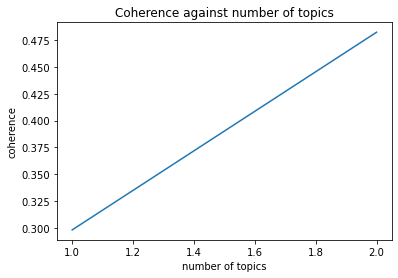

In [60]:
# plot coherence vs num_topics
num_topics = [_['num_topics'] for _ in validation_results]
coherences = np.array([_['coherence'] for _ in validation_results])
plt.plot(num_topics, coherences)

# annotate top three coherence scores
best_indices = np.argsort(coherences)[-5:]
for i in best_indices:
    bestk = num_topics[i]
    score = coherences[i]
    plt.plot(bestk, score, marker='x', color='black')
    plt.text(
        x=bestk+1, y=score, s=f"({bestk}, {score:.4})")

plt.title("Coherence against number of topics")
plt.ylabel("coherence")
plt.xlabel("number of topics")
plt.show()

In [62]:
print(validation_results)

[{'num_topics': 1, 'coherence': 0.29800223195986236}, {'num_topics': 2, 'coherence': 0.48242024158271574}, {'num_topics': 3, 'coherence': nan}, {'num_topics': 4, 'coherence': nan}, {'num_topics': 5, 'coherence': nan}, {'num_topics': 6, 'coherence': nan}, {'num_topics': 7, 'coherence': nan}, {'num_topics': 8, 'coherence': nan}, {'num_topics': 9, 'coherence': nan}, {'num_topics': 10, 'coherence': nan}, {'num_topics': 11, 'coherence': nan}, {'num_topics': 12, 'coherence': nan}, {'num_topics': 13, 'coherence': nan}, {'num_topics': 14, 'coherence': nan}, {'num_topics': 15, 'coherence': nan}, {'num_topics': 16, 'coherence': nan}, {'num_topics': 17, 'coherence': nan}, {'num_topics': 18, 'coherence': nan}, {'num_topics': 19, 'coherence': nan}, {'num_topics': 20, 'coherence': nan}, {'num_topics': 21, 'coherence': nan}, {'num_topics': 22, 'coherence': nan}, {'num_topics': 23, 'coherence': nan}, {'num_topics': 24, 'coherence': nan}, {'num_topics': 25, 'coherence': nan}, {'num_topics': 26, 'cohere